In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import re
import string
import itertools
from collections import Counter
import nltk
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [ ]:
def removePunctuations(text):
    remove = string.punctuation.replace("'", "") 
    pattern = r"[{}]".format(remove) 
    return re.sub(pattern, " ", text) 

def replaceDigitsWithd(text):
    return re.sub('\d', 'd', text)

def preprocessText(text):
    text = text.lower()
    text = text.replace("\n", " ")
    text = removePunctuations(text)
#     text = TextBlob(text).correct()
    text = replaceDigitsWithd(text)
    output = text.split(' ')
    output = list(filter(lambda a: a != '', output))
    return output

def getWordCounts(data):
    combinedList = list(itertools.chain.from_iterable(data))
    countDict = dict(Counter(combinedList))
    return countDict

def findCorrectSpelling(inputWord, countDict, minFreq):  
    minDistance = 1e10
    correctSpelling = inputWord
    for word in countDict.keys():        
        if inputWord != word:
            distance = nltk.edit_distance(word, inputWord)
            if distance < minDistance:
                minDistance = distance
                correctSpelling = word
    return correctSpelling

def getSpellingCorrections(countDict, minFreq = 5):
    corrections = {}
    words = countDict.keys()
    for word in words:
        if countDict[word] < minFreq:
            corrections[word] = findCorrectSpelling(word, countDict, minFreq)
    return corrections

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
dataset = pd.read_pickle('/content/drive/MyDrive/MIMIC/cleanData-4000.pkl')

In [ ]:
drop_max_len = 2200
dataset = dataset[dataset['PREPROCESSED_TEXT'].map(len) < drop_max_len]

In [ ]:
from ast import literal_eval
dataset['ICD9_CODE'] = dataset.ICD9_CODE.apply(lambda x: literal_eval(str(x)))

uniqCodes = set(itertools.chain.from_iterable(dataset['ICD9_CODE']))
code2idx = {code: idx for idx, code in enumerate(uniqCodes)}

dataset['Y'] = dataset['ICD9_CODE'].apply(lambda codeList: [code2idx[code] for code in codeList])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
dataset['Z'] = list(mlb.fit_transform(dataset.Y))

In [ ]:
dataset['CATEGORY'].value_counts()

Nursing/other        1245
Radiology            1224
ECG                   536
Nursing               414
Physician             234
Discharge summary     130
Echo                   95
Respiratory            30
General                15
Rehab Services         13
Nutrition              10
Social Work             2
Case Management         1
Name: CATEGORY, dtype: int64

In [ ]:
uniqueCats = set(dataset['CATEGORY'])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
dataset['CATOHE'] = list(ohe.fit_transform(dataset['CATEGORY'].values.reshape(-1,1)))

In [ ]:
num_records = len(dataset)
trainDf = dataset.iloc[:int(0.8*num_records)]
valDf = dataset.iloc[int(0.8*num_records):int(0.9*num_records)]
testDf = dataset.iloc[int(0.9*num_records):]

In [ ]:
tokenFreq = Counter(itertools.chain.from_iterable(dataset['PREPROCESSED_TEXT']))

tokenFreqTrain = Counter(itertools.chain.from_iterable(trainDf['PREPROCESSED_TEXT']))
word2idxTrain = {k: i+1 for i, k in enumerate(tokenFreqTrain.keys())}
word2idxTrain['unk'] = 0

In [ ]:
trainDf['X'] = trainDf['PREPROCESSED_TEXT'].apply(lambda words: [word2idxTrain[word] if word in word2idxTrain else 0 for word in words])
valDf['X'] = valDf['PREPROCESSED_TEXT'].apply(lambda words: [word2idxTrain[word] if word in word2idxTrain else 0 for word in words])
testDf['X'] = testDf['PREPROCESSED_TEXT'].apply(lambda words: [word2idxTrain[word] if word in word2idxTrain else 0 for word in words])

In [ ]:
dataset['REPORT_LENGTH'] = dataset.PREPROCESSED_TEXT.apply(lambda p: len(p))

(array([2675.,  736.,  210.,  103.,   54.,   44.,   37.,   39.,   27.,
          24.]),
 array([   3. ,  221.2,  439.4,  657.6,  875.8, 1094. , 1312.2, 1530.4,
        1748.6, 1966.8, 2185. ]),
 <a list of 10 Patch objects>)

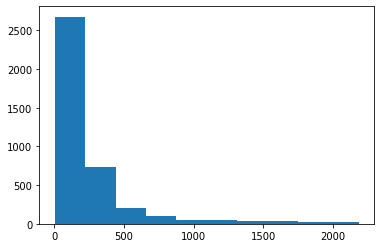

In [ ]:
plt.hist(dataset.REPORT_LENGTH)

In [ ]:
max_report_len = np.max(dataset['REPORT_LENGTH'])
max_report_len

2185

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        super().__init__()
        self.dataframe = dataframe
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return torch.tensor(row.X), row.CATOHE, row.Z
    
def my_collate(data):    
    Xs, Cats, Ys = zip(*data)    
    maxSize = max_report_len
    bz = len(Xs)
    
    y = torch.tensor(Ys, dtype=torch.float)
    cat = torch.tensor(Cats, dtype=torch.float)
    x = torch.zeros((bz, maxSize), dtype=torch.int)
    mask = torch.zeros((bz, maxSize), dtype=torch.bool)
    
    for i, X in enumerate(Xs):
        for j, wordIdx in enumerate(X):
            x[i][j] = wordIdx
            mask[i][j] = True
    
    return x, mask, cat, y

In [ ]:
class Model(nn.Module):    
    def __init__(self, num_words, out_classes, numCats, category_layers=-1, hidden_sizes=None ):
        super().__init__()
        self.category_layers = category_layers
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=300)
        prev_size = 300
        self.fc_layers = nn.ModuleList()
        if category_layers > -1:
            prev_size += numCats
        if category_layers > 0:
            for hsize in hidden_sizes:
                self.fc_layers.append(nn.Linear(prev_size, hsize))
                self.fc_layers.append(nn.Sigmoid())
                prev_size = hsize
        self.fc_final = nn.Linear(in_features=prev_size, out_features=out_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, mask, cat):
        try:
          x = self.embedding(x)
        except:
          print(torch.max(x))
          raise Exception('I know Python!')

        maskUnsq = mask.unsqueeze(-1)
        x = torch.sum(x*maskUnsq, dim=1)
        x = x/torch.sum(maskUnsq, dim=1)
        if(self.category_layers != -1):
            x = torch.cat((cat, x), dim=-1)
        if(self.category_layers > 0):
            for fc_layer in self.fc_layers:
                x = fc_layer(x)
        x = self.fc_final(x)
        x = self.sigmoid(x)
        return x

In [ ]:
def train(model, train_loader, val_loader, n_epochs, optimizer):
    the_last_val_loss = 1000
    patience = 4
    trigger_times = 0
    min_delta = 0.0001

    for epoch in range(n_epochs):
        iterations = 0
        model = model.cuda()
        model.train()
        train_loss = 0
        for x, mask, cat, y in train_loader: 
            x = x.cuda()
            mask = mask.cuda()           
            cat = cat.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            y_hat = model(x, mask, cat)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if iterations%10 == 0:             
              print('Iteration: {} \t Training Loss: {:.6f}'.format(iterations+1, train_loss/(iterations+1)))
            iterations += 1

        train_loss = train_loss / len(train_loader)
        print('*--------*')
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        val_loss, p, r, f = eval_model(model, val_loader)
        print('Epoch: {} \t Validation loss: {:.2f}, p: {:.2f}, r: {:.2f}, f1: {:.2f}'
              .format(epoch+1, val_loss, p, r, f))
        
        # Early stopping
        if val_loss > the_last_val_loss or (the_last_val_loss-val_loss)<min_delta:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model
        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_val_loss = val_loss

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
def eval_model(model, val_loader):
    model = model.cuda()    
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    val_loss = 0
    for x, mask, cat, y in val_loader:
        x = x.cuda()
        mask = mask.cuda()           
        cat = cat.cuda()
        y = y.cuda()
        y_hat = model(x, mask, cat)
        loss = criterion(y_hat, y)
        y_score = torch.cat((y_score,  y_hat.detach().to('cpu')), dim=0)
        y_hat = (y_hat > 0.5).int()
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)
        val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='samples')
    return val_loss, p, r, f

In [ ]:
train_dataloader = torch.utils.data.DataLoader(MyDataset(trainDf), batch_size=64, shuffle=True, collate_fn = my_collate, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(MyDataset(valDf), batch_size=64, shuffle=True, collate_fn = my_collate, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(MyDataset(testDf), batch_size=64, shuffle=True, collate_fn = my_collate, num_workers=8)

In [ ]:
vocabSize = len(word2idxTrain)
numCodes = len(uniqCodes)
nEpochs = 15
criterion = nn.BCELoss()

### BOT Baseline 

In [ ]:
model_cat_m1 = Model(vocabSize+1, numCodes, len(uniqueCats))
optimizer_cat_m1 = torch.optim.Adam(model_cat_m1.parameters(), lr=1e-3)

In [ ]:
train(model_cat_m1, train_dataloader, val_dataloader, nEpochs, optimizer_cat_m1)

Iteration: 1 	 Training Loss: 0.694348
Iteration: 11 	 Training Loss: 0.652414
Iteration: 21 	 Training Loss: 0.607637
Iteration: 31 	 Training Loss: 0.562363
Iteration: 41 	 Training Loss: 0.519418
Iteration: 51 	 Training Loss: 0.476403
Iteration: 61 	 Training Loss: 0.437020
Iteration: 71 	 Training Loss: 0.402326
Iteration: 81 	 Training Loss: 0.372457
Iteration: 91 	 Training Loss: 0.346694
*--------*
Epoch: 1 	 Training Loss: 0.328800
Epoch: 1 	 Validation loss: 0.11, p: 0.76, r: 0.09, f1: 0.15
trigger times: 0
Iteration: 1 	 Training Loss: 0.131687
Iteration: 11 	 Training Loss: 0.119270
Iteration: 21 	 Training Loss: 0.114613
Iteration: 31 	 Training Loss: 0.111742
Iteration: 41 	 Training Loss: 0.108760
Iteration: 51 	 Training Loss: 0.107732
Iteration: 61 	 Training Loss: 0.105626
Iteration: 71 	 Training Loss: 0.104819
Iteration: 81 	 Training Loss: 0.103719
Iteration: 91 	 Training Loss: 0.102705
*--------*
Epoch: 2 	 Training Loss: 0.102226
Epoch: 2 	 Validation loss: 0.09

Model(
  (embedding): Embedding(10932, 300)
  (fc_layers): ModuleList()
  (fc_final): Linear(in_features=300, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(model_cat_m1, test_dataloader)

(0.09427695559172691,
 0.6579746835443038,
 0.0810764249640881,
 0.14126848654160634)

### BOT Baseline w/ Cat 0 Dense

In [ ]:
model_cat_0 = Model(vocabSize+1, numCodes, len(uniqueCats), category_layers=0)
optimizer_cat_0 = torch.optim.Adam(model_cat_0.parameters(), lr=0.0001)

In [ ]:
train(model_cat_0, train_dataloader, val_dataloader, nEpochs, optimizer_cat_0)

Iteration: 1 	 Training Loss: 0.694384
Iteration: 11 	 Training Loss: 0.690100
Iteration: 21 	 Training Loss: 0.685443
Iteration: 31 	 Training Loss: 0.681042
Iteration: 41 	 Training Loss: 0.676279
Iteration: 51 	 Training Loss: 0.671620
Iteration: 61 	 Training Loss: 0.666686
Iteration: 71 	 Training Loss: 0.661970
Iteration: 81 	 Training Loss: 0.657114
Iteration: 91 	 Training Loss: 0.652179
*--------*
Epoch: 1 	 Training Loss: 0.648351
Epoch: 1 	 Validation loss: 0.60, p: 0.35, r: 0.12, f1: 0.15
trigger times: 0
Iteration: 1 	 Training Loss: 0.602780
Iteration: 11 	 Training Loss: 0.594628
Iteration: 21 	 Training Loss: 0.589145
Iteration: 31 	 Training Loss: 0.584318
Iteration: 41 	 Training Loss: 0.578791
Iteration: 51 	 Training Loss: 0.573265
Iteration: 61 	 Training Loss: 0.567345
Iteration: 71 	 Training Loss: 0.561904
Iteration: 81 	 Training Loss: 0.556913
Iteration: 91 	 Training Loss: 0.552097
*--------*
Epoch: 2 	 Training Loss: 0.547851
Epoch: 2 	 Validation loss: 0.49

In [ ]:
eval_model(model_cat_0, test_dataloader)

(0.09409197945194908,
 0.6565400843881856,
 0.07373869664493563,
 0.12987092563480096)

### BOT Baseline w/ Cat 1 Dense 

In [ ]:
model_cat_1 = Model(vocabSize+1, numCodes, len(uniqueCats), 1, [120])
optimizer_cat_1 = torch.optim.Adam(model_cat_1.parameters(), lr=0.001)

In [ ]:
train(model_cat_1, train_dataloader, val_dataloader, nEpochs, optimizer_cat_1)

Iteration: 1 	 Training Loss: 0.708303
Iteration: 11 	 Training Loss: 0.575477
Iteration: 21 	 Training Loss: 0.468103
Iteration: 31 	 Training Loss: 0.385046
Iteration: 41 	 Training Loss: 0.325617
Iteration: 51 	 Training Loss: 0.284005
Iteration: 61 	 Training Loss: 0.254523
Iteration: 71 	 Training Loss: 0.231711
Iteration: 81 	 Training Loss: 0.215124
Iteration: 91 	 Training Loss: 0.202204
*--------*
Epoch: 1 	 Training Loss: 0.193518
Epoch: 1 	 Validation loss: 0.09, p: 0.86, r: 0.06, f1: 0.11
trigger times: 0
Iteration: 1 	 Training Loss: 0.098797
Iteration: 11 	 Training Loss: 0.095975
Iteration: 21 	 Training Loss: 0.094770
Iteration: 31 	 Training Loss: 0.093723
Iteration: 41 	 Training Loss: 0.093295
Iteration: 51 	 Training Loss: 0.093651
Iteration: 61 	 Training Loss: 0.093302
Iteration: 71 	 Training Loss: 0.092895
Iteration: 81 	 Training Loss: 0.092474
Iteration: 91 	 Training Loss: 0.092204
*--------*
Epoch: 2 	 Training Loss: 0.091992
Epoch: 2 	 Validation loss: 0.09

Model(
  (embedding): Embedding(10932, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=313, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=120, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(model_cat_1, test_dataloader)

(0.09565376876087128,
 0.569620253164557,
 0.04238887639120817,
 0.07824123362627106)

### BOT Baseline w/ Cat 2 Dense 

In [ ]:
model_cat_2 = Model(vocabSize+1, numCodes, len(uniqueCats), 2, [200, 100])
optimizer_cat_2 = torch.optim.Adam(model_cat_2.parameters(), lr=0.001)

In [ ]:
train(model_cat_2, train_dataloader, val_dataloader, nEpochs, optimizer_cat_2)

Iteration: 1 	 Training Loss: 0.708341
Iteration: 11 	 Training Loss: 0.585886
Iteration: 21 	 Training Loss: 0.466138
Iteration: 31 	 Training Loss: 0.372883
Iteration: 41 	 Training Loss: 0.311251
Iteration: 51 	 Training Loss: 0.270631
Iteration: 61 	 Training Loss: 0.243202
Iteration: 71 	 Training Loss: 0.223015
Iteration: 81 	 Training Loss: 0.206897
Iteration: 91 	 Training Loss: 0.193936
*--------*
Epoch: 1 	 Training Loss: 0.185876
Epoch: 1 	 Validation loss: 0.09, p: 0.86, r: 0.06, f1: 0.11
trigger times: 0
Iteration: 1 	 Training Loss: 0.091418
Iteration: 11 	 Training Loss: 0.092973
Iteration: 21 	 Training Loss: 0.092853
Iteration: 31 	 Training Loss: 0.092963
Iteration: 41 	 Training Loss: 0.092341
Iteration: 51 	 Training Loss: 0.091493
Iteration: 61 	 Training Loss: 0.091499
Iteration: 71 	 Training Loss: 0.091508
Iteration: 81 	 Training Loss: 0.091842
Iteration: 91 	 Training Loss: 0.092073
*--------*
Epoch: 2 	 Training Loss: 0.091989
Epoch: 2 	 Validation loss: 0.09

Model(
  (embedding): Embedding(10932, 300)
  (fc_layers): ModuleList(
    (0): Linear(in_features=313, out_features=200, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=100, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(model_cat_2, test_dataloader)

(0.09607145641989345,
 0.6278481012658228,
 0.08782857159300315,
 0.15251033077033135)

### BOT Baseline w/ Cat 3 Dense 

In [ ]:
model_cat_3 = Model(vocabSize+1, numCodes, len(uniqueCats), 3, [230, 170, 110])
optimizer_cat_3 = torch.optim.Adam(model_cat_3.parameters(), lr=0.0001)

In [ ]:
train(model_cat_3, train_dataloader, val_dataloader, nEpochs, optimizer_cat_3)

Iteration: 1 	 Training Loss: 0.703343
Iteration: 11 	 Training Loss: 0.689539
Iteration: 21 	 Training Loss: 0.675695
Iteration: 31 	 Training Loss: 0.662110
Iteration: 41 	 Training Loss: 0.648427
Iteration: 51 	 Training Loss: 0.634524
Iteration: 61 	 Training Loss: 0.620221
Iteration: 71 	 Training Loss: 0.605448
Iteration: 81 	 Training Loss: 0.590238
Iteration: 91 	 Training Loss: 0.574664
*--------*
Epoch: 1 	 Training Loss: 0.561970
Epoch: 1 	 Validation loss: 0.40, p: 0.07, r: 0.10, f1: 0.08
trigger times: 0
Iteration: 1 	 Training Loss: 0.403444
Iteration: 11 	 Training Loss: 0.387686
Iteration: 21 	 Training Loss: 0.372086
Iteration: 31 	 Training Loss: 0.357699
Iteration: 41 	 Training Loss: 0.344063
Iteration: 51 	 Training Loss: 0.331059
Iteration: 61 	 Training Loss: 0.319479
Iteration: 71 	 Training Loss: 0.308802
Iteration: 81 	 Training Loss: 0.298639
Iteration: 91 	 Training Loss: 0.289231
*--------*
Epoch: 2 	 Training Loss: 0.282271
Epoch: 2 	 Validation loss: 0.19

In [ ]:
eval_model(model_cat_3, test_dataloader)

(0.08941374425835247,
 0.569620253164557,
 0.04238887639120817,
 0.07824123362627106)

### CNN Baseline 

In [ ]:
class CNNModel(nn.Module):    
    def __init__(self, num_words, out_classes, nCats, category_layers=-1, hidden_sizes=None):
        super().__init__()
        self.category_layers = category_layers
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=300)
        self.conv = nn.Conv1d(300, 3, 250)
        self.maxpool = nn.MaxPool1d(3, 2)
        prev_size = (3*(((max_report_len-252)//2)+1))
        self.fc_layers = nn.ModuleList()
        if category_layers > -1:
            prev_size += nCats
        if category_layers > 0:
            for hsize in hidden_sizes:
                self.fc_layers.append(nn.Linear(prev_size, hsize))
                self.fc_layers.append(nn.Sigmoid())
                prev_size = hsize
        self.fc_final = nn.Linear(in_features=prev_size, out_features=out_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, mask, cat):
        x = self.embedding(x)
        maskUnsq = mask.unsqueeze(-1)
        x = x*maskUnsq    # 32 x max_size x 300
        x = torch.permute(x, (0, 2, 1)) # 32 x 300 x max_size
        x = F.relu(self.conv(x)) # 32 x 3 x (max_size-249)
        x = self.maxpool(x)   # 32 x 3 x ((max_size-252)//2)+1
        x = torch.flatten(x, 1, -1) # 32 x (3*(((max_size-252)//2)+1))
        if(self.category_layers != -1):
            x = torch.cat((cat, x), dim=1)
        if(self.category_layers > 0):
            for fc_layer in self.fc_layers:
                x = fc_layer(x)
        x = self.fc_final(x)
        x = self.sigmoid(x)
        return x

### CNN Baseline 

In [ ]:
cnn_model_cat_m1 = CNNModel(vocabSize+1, numCodes, len(uniqueCats))
cnn_optimizer_cat_m1 = torch.optim.Adam(cnn_model_cat_m1.parameters(), lr=0.001)

In [ ]:
cnn_model_cat_m1

CNNModel(
  (embedding): Embedding(10932, 300)
  (conv): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList()
  (fc_final): Linear(in_features=2901, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
train(cnn_model_cat_m1, train_dataloader, val_dataloader, nEpochs, cnn_optimizer_cat_m1)

Iteration: 1 	 Training Loss: 0.692948
Iteration: 11 	 Training Loss: 0.391436
Iteration: 21 	 Training Loss: 0.305742
Iteration: 31 	 Training Loss: 0.249215
Iteration: 41 	 Training Loss: 0.214773
*--------*
Epoch: 1 	 Training Loss: 0.194227
Epoch: 1 	 Validation loss: 0.11, p: 0.74, r: 0.10, f1: 0.18
trigger times: 0
Iteration: 1 	 Training Loss: 0.108223
Iteration: 11 	 Training Loss: 0.095536
Iteration: 21 	 Training Loss: 0.093380
Iteration: 31 	 Training Loss: 0.091904
Iteration: 41 	 Training Loss: 0.091315
*--------*
Epoch: 2 	 Training Loss: 0.091293
Epoch: 2 	 Validation loss: 0.10, p: 0.74, r: 0.08, f1: 0.15
trigger times: 0
Iteration: 1 	 Training Loss: 0.077132
Iteration: 11 	 Training Loss: 0.083777
Iteration: 21 	 Training Loss: 0.083554
Iteration: 31 	 Training Loss: 0.083461
Iteration: 41 	 Training Loss: 0.083366
*--------*
Epoch: 3 	 Training Loss: 0.083427
Epoch: 3 	 Validation loss: 0.11, p: 0.71, r: 0.09, f1: 0.15
trigger times: 1
Iteration: 1 	 Training Loss: 0

CNNModel(
  (embedding): Embedding(10932, 300)
  (conv): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList()
  (fc_final): Linear(in_features=2901, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(cnn_model_cat_m1, test_dataloader)

(0.14461916897978103,
 0.5067497513080407,
 0.11061715254782621,
 0.16800660734235345)

### CNN Baseline w/ Cat 0 Dense 

In [ ]:
cnn_model_cat_0 = CNNModel(vocabSize+1, numCodes, len(uniqueCats), 0)
cnn_optimizer_cat_0 = torch.optim.Adam(cnn_model_cat_0.parameters(), lr=0.001)

In [ ]:
train(cnn_model_cat_0, train_dataloader, val_dataloader, nEpochs, cnn_optimizer_cat_0)

Iteration: 1 	 Training Loss: 0.694831
Iteration: 11 	 Training Loss: 0.398682
Iteration: 21 	 Training Loss: 0.289108
Iteration: 31 	 Training Loss: 0.234336
Iteration: 41 	 Training Loss: 0.203598
*--------*
Epoch: 1 	 Training Loss: 0.185440
Epoch: 1 	 Validation loss: 0.11, p: 0.75, r: 0.11, f1: 0.18
trigger times: 0
Iteration: 1 	 Training Loss: 0.093387
Iteration: 11 	 Training Loss: 0.093200
Iteration: 21 	 Training Loss: 0.093118
Iteration: 31 	 Training Loss: 0.092976
Iteration: 41 	 Training Loss: 0.092184
*--------*
Epoch: 2 	 Training Loss: 0.091490
Epoch: 2 	 Validation loss: 0.10, p: 0.76, r: 0.09, f1: 0.16
trigger times: 0
Iteration: 1 	 Training Loss: 0.081804
Iteration: 11 	 Training Loss: 0.082898
Iteration: 21 	 Training Loss: 0.085185
Iteration: 31 	 Training Loss: 0.085207
Iteration: 41 	 Training Loss: 0.084320
*--------*
Epoch: 3 	 Training Loss: 0.084139
Epoch: 3 	 Validation loss: 0.11, p: 0.72, r: 0.09, f1: 0.16
trigger times: 1
Iteration: 1 	 Training Loss: 0

CNNModel(
  (embedding): Embedding(10932, 300)
  (conv): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList()
  (fc_final): Linear(in_features=2914, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(cnn_model_cat_0, test_dataloader)

(0.1420590387923377,
 0.4885071709587778,
 0.10913527394344105,
 0.1603614585368459)

### CNN Baseline w/ Cat 1 Dense 

In [ ]:
cnn_model_cat_1 = CNNModel(vocabSize+1, numCodes,len(uniqueCats), 1, [3000])
cnn_optimizer_cat_1 = torch.optim.Adam(cnn_model_cat_1.parameters(), lr=0.001)

In [ ]:
train(cnn_model_cat_1, train_dataloader, val_dataloader, nEpochs, cnn_optimizer_cat_1)

Iteration: 1 	 Training Loss: 0.703784
Iteration: 11 	 Training Loss: 0.180150
Iteration: 21 	 Training Loss: 0.142965
Iteration: 31 	 Training Loss: 0.127438
Iteration: 41 	 Training Loss: 0.119975
*--------*
Epoch: 1 	 Training Loss: 0.114819
Epoch: 1 	 Validation loss: 0.10, p: 0.85, r: 0.06, f1: 0.11
trigger times: 0
Iteration: 1 	 Training Loss: 0.089805
Iteration: 11 	 Training Loss: 0.093528
Iteration: 21 	 Training Loss: 0.091884
Iteration: 31 	 Training Loss: 0.090997
Iteration: 41 	 Training Loss: 0.091233
*--------*
Epoch: 2 	 Training Loss: 0.091357
Epoch: 2 	 Validation loss: 0.10, p: 0.78, r: 0.14, f1: 0.23
trigger times: 1
Iteration: 1 	 Training Loss: 0.089832
Iteration: 11 	 Training Loss: 0.091027
Iteration: 21 	 Training Loss: 0.089963
Iteration: 31 	 Training Loss: 0.089196
Iteration: 41 	 Training Loss: 0.089338
*--------*
Epoch: 3 	 Training Loss: 0.089247
Epoch: 3 	 Validation loss: 0.10, p: 0.69, r: 0.11, f1: 0.19
trigger times: 2
Iteration: 1 	 Training Loss: 0

CNNModel(
  (embedding): Embedding(10932, 300)
  (conv): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=2914, out_features=3000, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=3000, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(cnn_model_cat_1, test_dataloader)

(0.13450709411076137,
 0.37006827645413415,
 0.0989203216608084,
 0.14674322703891687)

### CNN Baseline w/ Cat 2 Dense 

In [ ]:
cnn_model_cat_2 = CNNModel(vocabSize+1, numCodes, len(uniqueCats), 2, [3000, 500])
cnn_optimizer_cat_2 = torch.optim.Adam(cnn_model_cat_2.parameters(), lr=0.001)

In [ ]:
train(cnn_model_cat_2, train_dataloader, val_dataloader, nEpochs, cnn_optimizer_cat_2)

Iteration: 1 	 Training Loss: 0.704971
Iteration: 11 	 Training Loss: 0.294200
Iteration: 21 	 Training Loss: 0.201765
Iteration: 31 	 Training Loss: 0.167068
Iteration: 41 	 Training Loss: 0.148904
*--------*
Epoch: 1 	 Training Loss: 0.139122
Epoch: 1 	 Validation loss: 0.09, p: 0.85, r: 0.11, f1: 0.19
trigger times: 0
Iteration: 1 	 Training Loss: 0.093766
Iteration: 11 	 Training Loss: 0.093849
Iteration: 21 	 Training Loss: 0.091988
Iteration: 31 	 Training Loss: 0.092504
Iteration: 41 	 Training Loss: 0.091775
*--------*
Epoch: 2 	 Training Loss: 0.091382
Epoch: 2 	 Validation loss: 0.10, p: 0.71, r: 0.10, f1: 0.17
trigger times: 1
Iteration: 1 	 Training Loss: 0.091420
Iteration: 11 	 Training Loss: 0.093645
Iteration: 21 	 Training Loss: 0.092197
Iteration: 31 	 Training Loss: 0.091985
Iteration: 41 	 Training Loss: 0.091500
*--------*
Epoch: 3 	 Training Loss: 0.091165
Epoch: 3 	 Validation loss: 0.10, p: 0.71, r: 0.10, f1: 0.17
trigger times: 2
Iteration: 1 	 Training Loss: 0

CNNModel(
  (embedding): Embedding(10932, 300)
  (conv): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=2914, out_features=3000, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3000, out_features=500, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=500, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(cnn_model_cat_2, test_dataloader)

(0.09837424222912107,
 0.7139240506329114,
 0.15398038464215916,
 0.24977509499161732)

### CNN Baseline w/ Cat 3 Dense 

In [ ]:
cnn_model_cat_3 = CNNModel(vocabSize+1, numCodes, len(uniqueCats), 3, [3000, 700, 200])
cnn_optimizer_cat_3 = torch.optim.Adam(cnn_model_cat_3.parameters(), lr=0.001)

In [ ]:
train(cnn_model_cat_3, train_dataloader, val_dataloader, nEpochs, cnn_optimizer_cat_3)

Iteration: 1 	 Training Loss: 0.702221
Iteration: 11 	 Training Loss: 0.451103
Iteration: 21 	 Training Loss: 0.305266
Iteration: 31 	 Training Loss: 0.239177
Iteration: 41 	 Training Loss: 0.204168
*--------*
Epoch: 1 	 Training Loss: 0.183494
Epoch: 1 	 Validation loss: 0.09, p: 0.85, r: 0.11, f1: 0.19
trigger times: 0
Iteration: 1 	 Training Loss: 0.087790
Iteration: 11 	 Training Loss: 0.090504
Iteration: 21 	 Training Loss: 0.090300
Iteration: 31 	 Training Loss: 0.091197
Iteration: 41 	 Training Loss: 0.091375
*--------*
Epoch: 2 	 Training Loss: 0.091435
Epoch: 2 	 Validation loss: 0.09, p: 0.86, r: 0.06, f1: 0.11
trigger times: 1
Iteration: 1 	 Training Loss: 0.085054
Iteration: 11 	 Training Loss: 0.089327
Iteration: 21 	 Training Loss: 0.089370
Iteration: 31 	 Training Loss: 0.090536
Iteration: 41 	 Training Loss: 0.090760
*--------*
Epoch: 3 	 Training Loss: 0.091121
Epoch: 3 	 Validation loss: 0.09, p: 0.86, r: 0.06, f1: 0.11
trigger times: 2
Iteration: 1 	 Training Loss: 0

In [ ]:
eval_model(cnn_model_cat_3, test_dataloader)

(0.1038111224770546,
 0.569620253164557,
 0.04238887639120817,
 0.07824123362627106)

### CNN 3-Conv1D

In [ ]:
class CNN3ConvModel(nn.Module):    
    def __init__(self, num_words, out_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=300)
        self.conv1 = nn.Conv1d(300, 2, 250)
        self.conv2 = nn.Conv1d(300, 3, 250)
        self.conv3 = nn.Conv1d(300, 4, 250)
        self.maxpool = nn.MaxPool1d(3, 2)
        prev_size = (3*(((max_report_len-251)//2)+1)) + (3*(((max_report_len-252)//2)+1)) + (3*(((max_report_len-253)//2)+1)) -3
        self.fc_final = nn.Linear(in_features=prev_size, out_features=out_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, mask, cat):
        x = self.embedding(x)
        maskUnsq = mask.unsqueeze(-1)
        x = x*maskUnsq    # 32 x max_size x 300
        x = torch.permute(x, (0, 2, 1)) # 32 x 300 x max_size

        x1 = F.relu(self.conv1(x)) # 32 x 250 x (max_size-1)
        x1 = self.maxpool(x1)   # 32 x 250 x ((max_size-4)//2)+1

        x2 = F.relu(self.conv2(x)) # 32 x 250 x (max_size-2)
        x2 = self.maxpool(x2)   # 32 x 250 x ((max_size-5)//2)+1

        x3 = F.relu(self.conv3(x)) # 32 x 250 x (max_size-3)
        x3 = self.maxpool(x3)   # 32 x 250 x ((max_size-6)//2)+1
  
        x1 = torch.flatten(x1, 1, -1) # 32 x (250*(((max_size-4)//2)+1))
        x2 = torch.flatten(x2, 1, -1) # 32 x (250*(((max_size-5)//2)+1))
        x3 = torch.flatten(x3, 1, -1) # 32 x (250*(((max_size-6)//2)+1))

        x = torch.cat((x1, x2, x3), dim=-1)
        x = self.fc_final(x)
        x = self.sigmoid(x)
        return x

In [ ]:
cnn3_model = CNN3ConvModel(vocabSize+1, numCodes)
cnn3_optimizer = torch.optim.Adam(cnn3_model.parameters(), lr=0.001)

In [ ]:
train(cnn3_model, train_dataloader, val_dataloader, nEpochs, cnn3_optimizer)

Iteration: 1 	 Training Loss: 0.695636
Iteration: 11 	 Training Loss: 0.399785
Iteration: 21 	 Training Loss: 0.324538
Iteration: 31 	 Training Loss: 0.268383
Iteration: 41 	 Training Loss: 0.228748
*--------*
Epoch: 1 	 Training Loss: 0.204987
Epoch: 1 	 Validation loss: 0.10, p: 0.77, r: 0.08, f1: 0.14
trigger times: 0
Iteration: 1 	 Training Loss: 0.096259
Iteration: 11 	 Training Loss: 0.091312
Iteration: 21 	 Training Loss: 0.089393
Iteration: 31 	 Training Loss: 0.088944
Iteration: 41 	 Training Loss: 0.088103
*--------*
Epoch: 2 	 Training Loss: 0.087731
Epoch: 2 	 Validation loss: 0.10, p: 0.75, r: 0.09, f1: 0.16
trigger times: 1
Iteration: 1 	 Training Loss: 0.079027
Iteration: 11 	 Training Loss: 0.078640
Iteration: 21 	 Training Loss: 0.077874
Iteration: 31 	 Training Loss: 0.077287
Iteration: 41 	 Training Loss: 0.077694
*--------*
Epoch: 3 	 Training Loss: 0.077339
Epoch: 3 	 Validation loss: 0.12, p: 0.67, r: 0.11, f1: 0.18
trigger times: 2
Iteration: 1 	 Training Loss: 0

CNN3ConvModel(
  (embedding): Embedding(10932, 300)
  (conv1): Conv1d(300, 2, kernel_size=(250,), stride=(1,))
  (conv2): Conv1d(300, 3, kernel_size=(250,), stride=(1,))
  (conv3): Conv1d(300, 4, kernel_size=(250,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_final): Linear(in_features=8703, out_features=649, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
eval_model(cnn3_model, test_dataloader)

(0.1336854887860162,
 0.5238137336313062,
 0.10876606049522144,
 0.1696703450825693)